## Collecting and Saving Images as LMDB files

In [1]:
import re
import cv2
import lmdb
import pickle
import os
from tqdm import tqdm
from sklearn import preprocessing
import numpy as np

In [49]:
def capture_faces(num_faces=1000, face_size=(128, 128)):
    
    name = str(input("Please enter your first name: "))
    output_path = os.path.join("data", f"{name}.lmdb")
    # Initialize face detector
    facedetect = cv2.CascadeClassifier('models\haarcascade_frontalface_default.xml')
    
    # Create LMDB environment
    map_size = num_faces * 1024 * 1024 * 3  
    env = lmdb.open(output_path, map_size=map_size)

    # Initialize webcam
    cam = cv2.VideoCapture(0)
    
    saved_count = 0
    progress = tqdm(total=num_faces, desc="Saving faces")

    try:
        with env.begin(write=True) as txn:
            while saved_count < num_faces:
                ret, frame = cam.read()
                if not ret:
                    continue

                # Detect faces
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces = facedetect.detectMultiScale(gray, 1.3, 5)

                for (x, y, w, h) in faces:
                    # Extract and resize face
                    face_img = frame[y:y+h, x:x+w]
                    resized_face = cv2.resize(face_img, face_size)

                    # Store in LMDB
                    key = f"face_{saved_count:08d}".encode()
                    txn.put(key, pickle.dumps(resized_face))
                    
                    saved_count += 1
                    progress.update(1)
                    
                    # Display current face count on the frame
                    cv2.putText(frame, str(saved_count), (50,50), cv2.FONT_HERSHEY_COMPLEX, 1, (50,50,255), 1)
        
                    # Draw rectangle around detected face
                    cv2.rectangle(frame, (x,y), (x+w, y+h), (50,50,255), 1)
              
                # Show preview
                cv2.imshow('Face Capture', frame)
                
                # Exit on key ('q') pressed or completion (100 faces collected)
                k=cv2.waitKey(1)
                if k==ord('q') or len(faces_data)==1000:
                    break

    finally:
        cam.release()
        cv2.destroyAllWindows()
        progress.close()
        print(f"\nSaved {saved_count} faces")



# Capture 1000 faces to database
capture_faces()
   


<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
C:\Users\DELL\AppData\Local\Temp\ipykernel_15484\3023620433.py:12: SyntaxWarning: invalid escape sequence '\h'
  facedetect = cv2.CascadeClassifier('models\haarcascade_frontalface_default.xml')


Please enter your first name:  KC


Saving faces: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.22it/s]


Saved 1000 faces


In [59]:
def view_image(lmdb_path, key_to_view):

    # Open LMDB environment in read-only mode
    env = lmdb.open(lmdb_path, readonly=True)
    
    with env.begin() as txn:
        # Retrieve the serialized image data using the key
        value = txn.get(key_to_view.encode())
        if value is None:
            print(f"No data found for key: {key_to_view}")
            return
        
        # Deserialize the data back into a numpy array
        image = pickle.loads(value)
        
        # Display the image using OpenCV
        cv2.imshow(f"Image: {key_to_view}", image)
        cv2.waitKey(0)  # Wait for a key press to close the window
        cv2.destroyAllWindows()


lmdb_path = "data\Peace.lmdb" 
key_to_view = "face_00000001"  
view_image(lmdb_path, key_to_view)


<>:22: SyntaxWarning: invalid escape sequence '\P'
<>:22: SyntaxWarning: invalid escape sequence '\P'
C:\Users\DELL\AppData\Local\Temp\ipykernel_15484\2113577972.py:22: SyntaxWarning: invalid escape sequence '\P'
  lmdb_path = "data\Peace.lmdb"


## Load Training Data

In [3]:
def get_images(lmdb_path, features, labels):
   
    env = lmdb.open(lmdb_path, readonly=True)
    
    pattern = r"\\(.*)\."
    match = re.search(pattern, lmdb_path)
    name = match.group(1)[1:]
    
    
    with env.begin() as txn:
        cursor = txn.cursor()
        for key, value in cursor:
            key_str = key.decode()  # Decode key from bytes to string
            key_str += name
            image = pickle.loads(value)  # Deserialize image data back into a numpy array
            labels.append(name)
            features.append(image)
    
    return features, labels




In [5]:
dir = "data"
features = []
labels = []
for path in os.listdir(dir):
    lmdb_path = os.path.join(dir,path)
    features, labels = get_images(lmdb_path, features, labels)

In [7]:
label_encoder = preprocessing.LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [9]:
len(labels)

2000

In [11]:
features = np.array(features) 
labels = np.array(labels)

In [13]:
np.unique(labels)

array([0, 1], dtype=int64)

## Train Model

In [15]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D, 
    Activation, 
    BatchNormalization, 
    MaxPooling2D, 
    Dropout, 
    Flatten, 
    Dense
)
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping,TensorBoard,ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [81]:
# Initiating model on GPU
def build():
    model = Sequential()
    model.add(Input(shape = (128, 128, 3)))
    # Feature Learning Layers with Kernel size (3x3), Step size (1 pixel)
    model.add(Conv2D(32,(3, 3),strides=(1, 1),padding='same'))
    model.add(Activation('relu'))# Activation function
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    # Flattening tensors
    model.add(Flatten())

    # Fully-Connected Layers
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(1, activation = 'sigmoid')) # binaryClassification layer
    return model

In [83]:
model = build()

In [85]:
# Compiling model
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy', # change to sparse_categorical_crossentropy for multiclass where each sample can only belong to one class
              metrics = ['accuracy']) # Evaluation metric

In [87]:
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_loss', 
                               min_delta = 0.01,
                               mode = 'min',
                               patience = 7,
                               start_from_epoch = 20,
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model.keras',
                            monitor = 'val_loss',
                            save_best_only = True)

In [89]:
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=  1, validation_data = (X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8439 - loss: 2.8288 - val_accuracy: 0.5100 - val_loss: 3468.0435
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9929 - loss: 0.1702 - val_accuracy: 0.5100 - val_loss: 3473.4360
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.9990 - loss: 0.0125 - val_accuracy: 0.5100 - val_loss: 932.8412
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.9992 - loss: 0.0396 - val_accuracy: 0.5167 - val_loss: 277.9084
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.7100 - val_loss: 55.5258
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.9993 - loss: 0.0061 - val_accuracy: 0.8633 - val_loss: 10.6264
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 334s 16s/step - accuracy: 1.0000 - loss: 2.9549e-08 - val_accuracy: 0.9600 - val_loss: 3.4463
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9991 - loss: 0.0168 - val_ac

In [91]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.keras')

## Evaluate Model

In [93]:
best_model.evaluate(X_test, y_test, batch_size=64, verbose=1) 

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 537ms/step - accuracy: 1.0000 - loss: 2.6742e-12


[5.005305198091392e-12, 1.0]

## Tune Hyperparameters

## Save Model

In [95]:
with open('face_recog_model.pkl', 'wb') as file:  # 'wb' for writing in binary mode
    pickle.dump(best_model, file)

## Test Case

Get files of pictures and labels for test predictions and evaluate.

In [99]:
y_pred = best_model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step


In [101]:
classification_report(y_test, y_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [77]:
# plot confusion matrix
cm1 = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(cm1).plot()
plt.show()

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

## Saving Images as BLOB to Postgresql database

In [1]:
import cv2
import numpy as np
import os
 
name = str(input("Please enter your first name: "))

video=cv2.VideoCapture(0)

facedetect=cv2.CascadeClassifier('models\haarcascade_frontalface_default.xml')

faces_data = []  # Empty list to store resized face images
i = 0  # Counter to track processed frames

while True:
    # Read a frame from the video source (webcam/file)
    ret,frame=video.read()
    
    # Convert frame to grayscale (face detection works better on grayscale)
    gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces using the haar cascade pre-trained classifier
    faces=facedetect.detectMultiScale(gray, 1.3 ,5)
    
    for (x, y, w, h) in faces:
        # Crop the face region from the frame
        crop_img = frame[y:y+h, x:x+w, :]
        
        # Resize cropped face to 50x50 pixels 
        resized_img = cv2.resize(crop_img, (50, 50))
        
        # Collect every 10th face until 100 faces are stored
        if len(faces_data) <= 10 and i % 10 == 0:
            faces_data.append(resized_img)
            
        # Increment frame counter
        i += 1
        
        # Display current face count on the frame
        cv2.putText(frame, str(len(faces_data)), (50,50), cv2.FONT_HERSHEY_COMPLEX, 1, (50,50,255), 1)
        
        # Draw rectangle around detected face
        cv2.rectangle(frame, (x,y), (x+w, y+h), (50,50,255), 1)

    # Show the processed frame
    cv2.imshow("Frame", frame)
    
    # Check for exit key ('q') or completion (100 faces collected)
    k=cv2.waitKey(1)
    if k==ord('q') or len(faces_data)==10:
        break

video.release()
cv2.destroyAllWindows()

#faces_data=np.asarray(faces_data)

<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\h'
C:\Users\DELL\AppData\Local\Temp\ipykernel_15484\3216854562.py:9: SyntaxWarning: invalid escape sequence '\h'
  facedetect=cv2.CascadeClassifier('models\haarcascade_frontalface_default.xml')


Please enter your first name:  Peace


C:\Users\DELL\AppData\Local\Temp\ipykernel_15484\3216854562.py:9: SyntaxWarning: invalid escape sequence '\h'
  facedetect=cv2.CascadeClassifier('models\haarcascade_frontalface_default.xml')


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
import psycopg2 

# Connect to the postgreSQL database 
def create_connection(): 
    conn = psycopg2.connect(dbname='FaceRecog', 
                            user='postgres', 
                            password='Ifechukwu', #st.secret[]
                            host='localhost', 
                            port='5432') 
    # Get the cursor object from the connection object 
    curr = conn.cursor() 
    return conn, curr 
  
def create_table(): 
    
    try: 
        # Get the cursor object from the connection object 
        conn, curr = create_connection() 
        try: 
            # Fire the CREATE query 
            curr.execute("DROP TABLE authorized") 
            curr.execute("CREATE TABLE IF NOT EXISTS authorized(personID TEXT, name TEXT, faceImg BYTEA)") 
              
        except(Exception, psycopg2.Error) as error: 
            # Print exception 
            print("Error while creating authorized table", error) 
        finally: 
            # Close the connection object 
            conn.commit() 
            conn.close() 
    finally: 
        # Since we do not have to do anything here we will pass 
        pass
  
def write_blob(personID,face,name): 
    try:  
        # Read database configuration 
        conn, cursor = create_connection() 
        try:            
            # Execute the INSERT statement 
            # Convert the image data to Binary 
            cursor.execute("INSERT INTO authorized (personID,name,faceImg) " + "VALUES(%s,%s,%s)", (personID,name, psycopg2.Binary(face))) 
            # Commit the changes to the database 
            conn.commit() 
        except (Exception, psycopg2.DatabaseError) as error: 
            print("Error while inserting data in authorized table", error) 
        finally: 
            # Close the connection object 
            conn.close() 
    finally: 
        # Since we do not have to do anything here we will pass 
        pass
    print("Saved faces")
        
# Call the create table method       
create_table() 
# Prepare sample data, of images, from local drive 
for i, face in enumerate(faces_data):
    personID = name+str(i)
    write_blob(personID,face,name)


In [11]:
import psycopg2 
# Connect to the postgreSQL database 
def create_connection(): 
    conn = psycopg2.connect(dbname='FaceRecog', 
                            user='postgres', 
                            password='Ifechukwu', #st.secret[]
                            host='localhost', 
                            port='5432') 
    # Get the cursor object from the connection object 
    curr = conn.cursor() 
    return conn, curr 

In [13]:
import pandas as pd
def read_img(): 
    conn, curr = create_connection() 
    curr.execute("SELECT * FROM authorized")
    rows = curr.fetchall()
    df = pd.DataFrame(rows, columns=["PersonID","name","face"])
    return df
    
df = read_img()
print(df)

   PersonID   name                                               face
0    Peace0  Peace  [b'r', b'\x82', b'\xb3', b'p', b'\x7f', b'\xb0...
1    Peace1  Peace  [b'~', b'~', b'~', b'\x80', b'\x80', b'\x80', ...
2    Peace2  Peace  [b'\x8a', b'\x8a', b'\x8a', b'\x8a', b'\x8c', ...
3    Peace3  Peace  [b'\x83', b'\x82', b'~', b'\x84', b'\x83', b'\...
4    Peace4  Peace  [b'\x7f', b'}', b'|', b'\x80', b'\x81', b'\x7f...
5    Peace5  Peace  [b'\x80', b'\x80', b'\x80', b'\x7f', b'{', b'\...
6    Peace6  Peace  [b'\xd8', b'\xe0', b'\xe6', b'\xc9', b'\xca', ...
7    Peace7  Peace  [b'K', b'J', b'N', b'L', b'K', b'O', b'L', b'K...
8    Peace8  Peace  [b'\x95', b'\x97', b'\x92', b'\x8f', b'\x93', ...
9    Peace0  Peace  [b'\xc1', b'\xc5', b'\xd0', b'\xc1', b'\xc5', ...
10   Peace1  Peace  [b'v', b'{', b'{', b'y', b'}', b'~', b'w', b'{...
11   Peace2  Peace  [b'z', b'\x7f', b'~', b'~', b'\x84', b'\x80', ...
12   Peace3  Peace  [b'y', b'~', b'y', b'\x81', b'\x82', b'\x80', ...
13   Peace4  Peace  

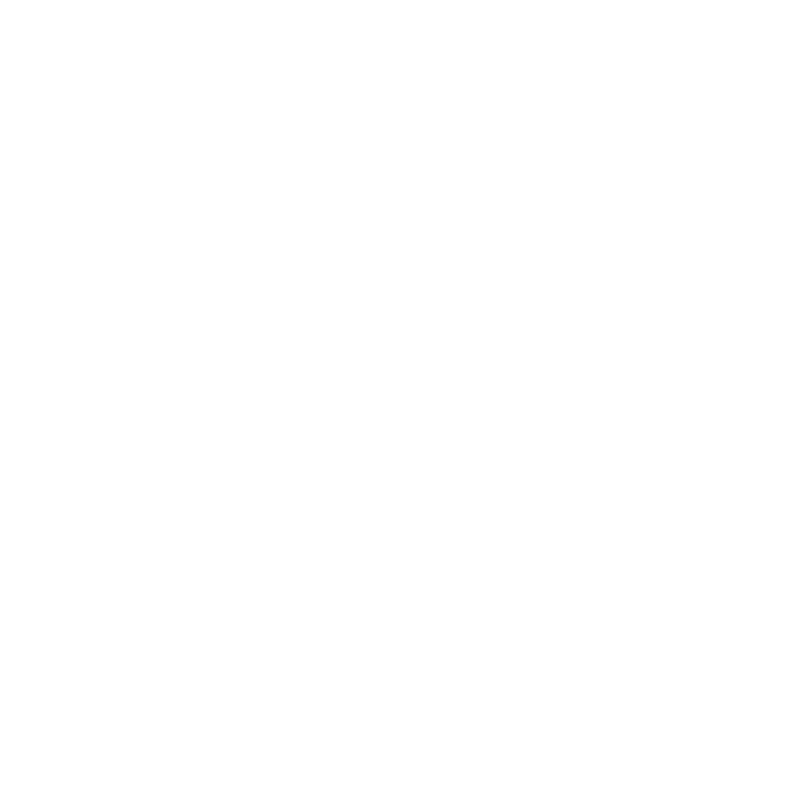

In [15]:
import matplotlib.pyplot as plt
import numpy
import base64
head = df.head()
def Display_images(head):
    plt.figure(figsize=(10, 10))
    for images in head.face:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            blob = base64.b64encode(images[i]).decode('utf-8')
            #plt.title(class_names[labels[i]])
            plt.axis("off")
            
Display_images(df)

In [ ]:
https://youtu.be/NwvTh-gkdfs?si=i88ZDcKSbz8mlzDI